C:\Users\Becode-son\AppData\Local\Temp\ipykernel_12204\2954939088.py:140: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_pizza_restaurants_per_source = pizza_restaurants_df.groupby('source', group_keys=False).apply(lambda x: x.nlargest(10, 'weighted_rating')).reset_index(drop=True)


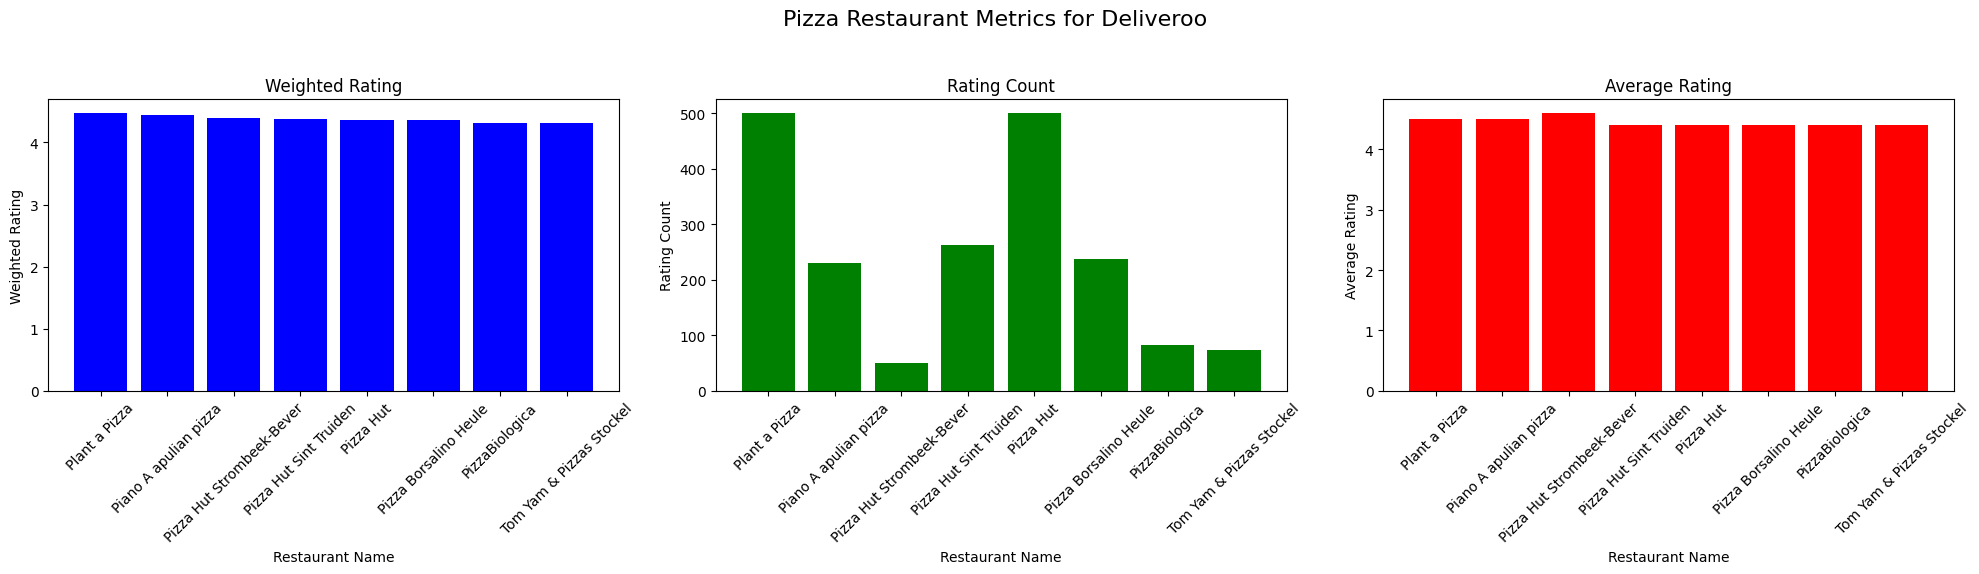

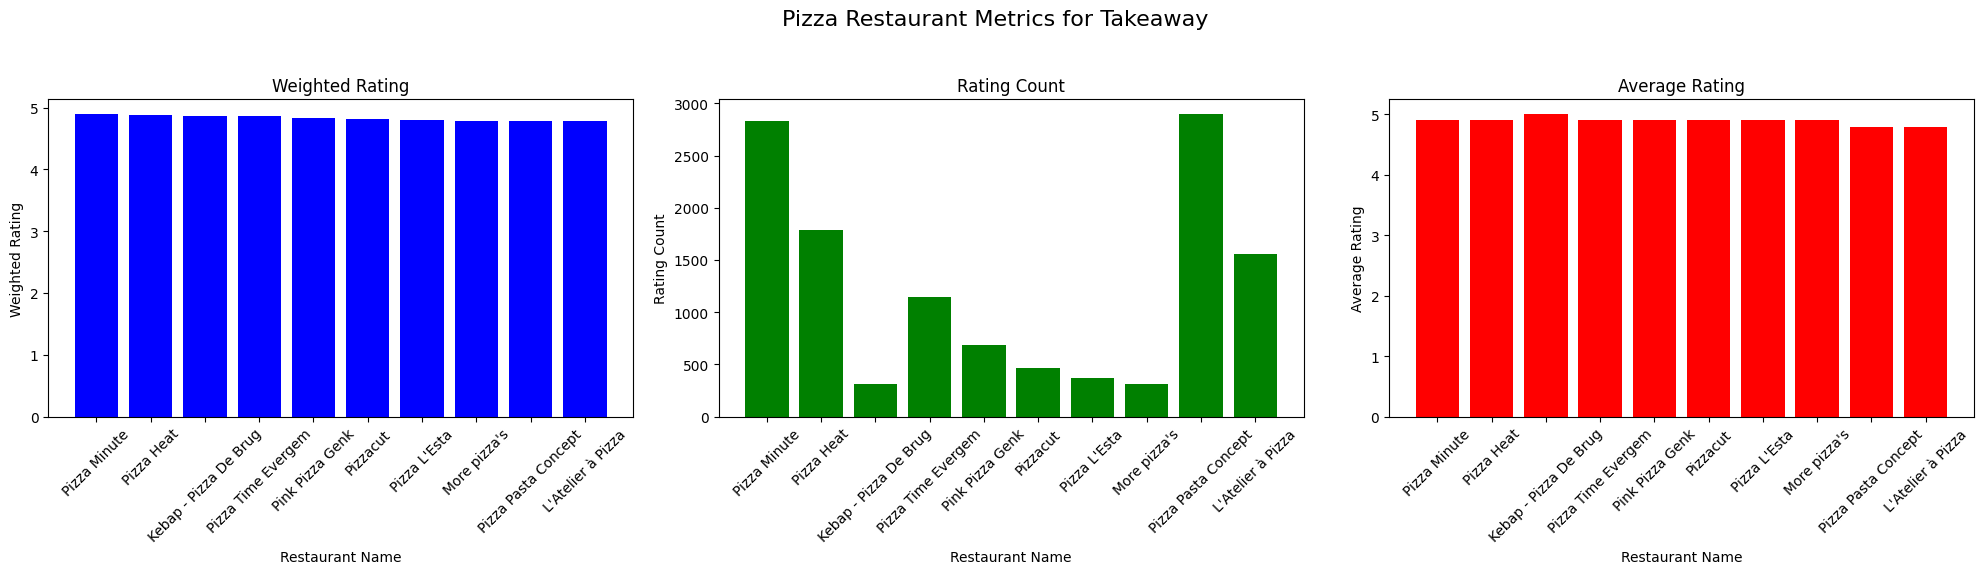

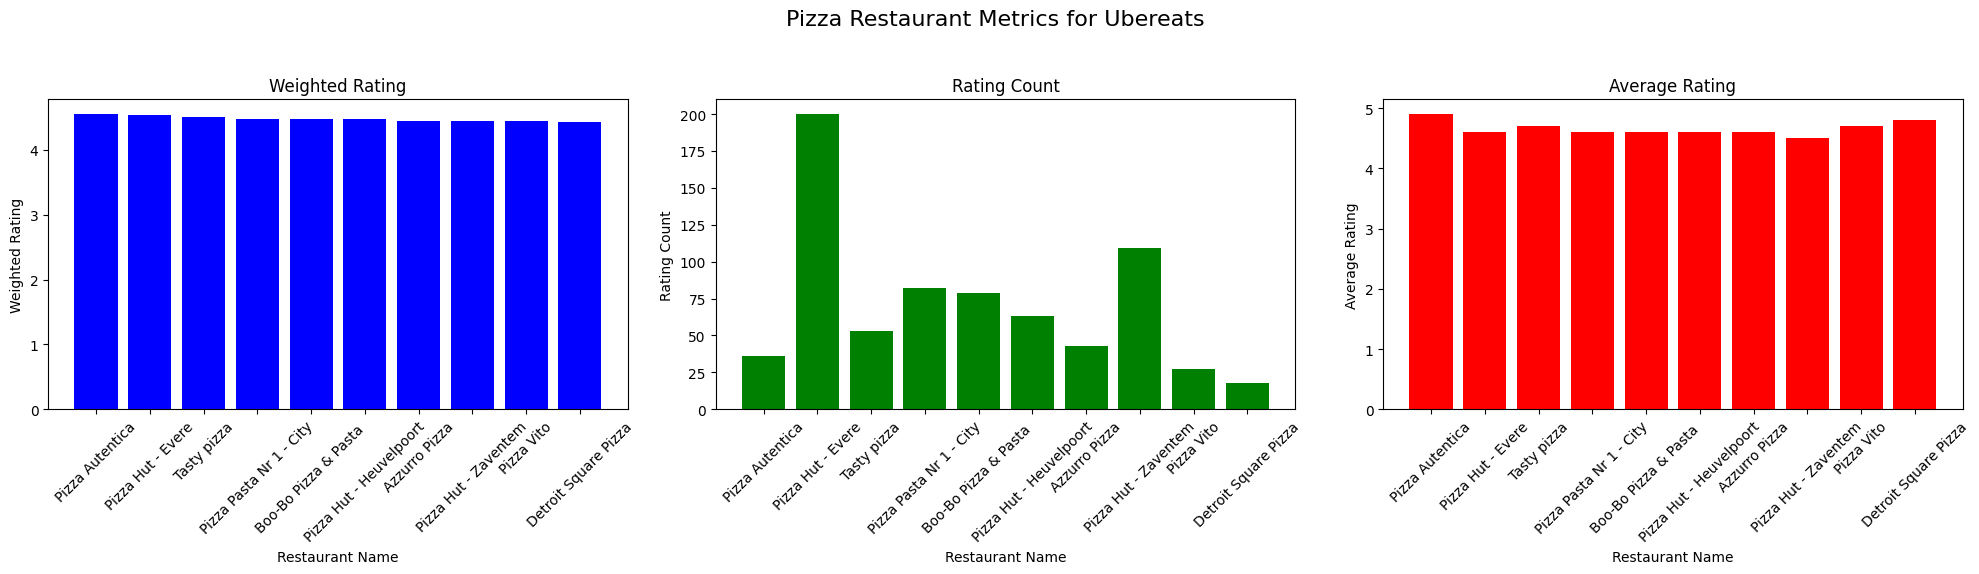

In [1]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt



# Function to load restaurant data with weighted rating
def load_restaurant_data_with_weighted_rating(db_file, db_id, m=50):
    """
    Load restaurant data from each database and include a calculated weighted rating.
    Handle missing values for ratings and rating numbers.
    """
    if not os.path.exists(db_file):
        print(f"Error: Database file {db_file} does not exist.")
        return pd.DataFrame()  # Return empty DataFrame if the file is missing

    conn = sqlite3.connect(db_file)
    try:
        if db_id == "deliveroo":
            # Get average rating for Deliveroo
            avg_rating_query = "SELECT AVG(rating) FROM restaurants WHERE rating IS NOT NULL AND rating_number > 0"
            c = pd.read_sql_query(avg_rating_query, conn).iloc[0, 0]

            query = f"""
            SELECT 
                name AS restaurant_name, 
                address AS address,
                postal_code AS postal_code,
                CAST(longitude AS REAL) AS longitude, 
                CAST(latitude AS REAL) AS latitude, 
                rating,
                CAST(rating_number AS INTEGER) AS rating_number,
                ((rating_number * rating) + ({m} * {c})) / (rating_number + {m}) AS weighted_rating,
                '{db_id}' AS source
            FROM restaurants
            WHERE rating IS NOT NULL AND rating_number > 0
            """
            return pd.read_sql_query(query, conn)

        elif db_id == "takeaway":
            # Get average rating for Takeaway
            avg_rating_query = "SELECT AVG(ratings) FROM restaurants WHERE ratings IS NOT NULL AND ratingsNumber > 0"
            c = pd.read_sql_query(avg_rating_query, conn).iloc[0, 0]

            # Main restaurant data query
            query = f"""
            SELECT 
                name AS restaurant_name, 
                address AS address,
                city AS city,
                CAST(longitude AS REAL) AS longitude, 
                CAST(latitude AS REAL) AS latitude, 
                ratings AS rating,
                primarySlug AS restaurant_id,
                CAST(ratingsNumber AS INTEGER) AS rating_number,
                ((ratingsNumber * ratings) + ({m} * {c})) / (ratingsNumber + {m}) AS weighted_rating,
                '{db_id}' AS source
            FROM restaurants
            WHERE ratings IS NOT NULL AND ratingsNumber > 0
            """
            restaurant_df = pd.read_sql_query(query, conn)

            # Load postal codes and restaurant counts
            postal_code_query = """
            SELECT
                COUNT(DISTINCT restaurants.name) as total_restaurants,
                locations.postalCode AS postal_code
            FROM
                restaurants
            INNER JOIN
                locations_to_restaurants
            ON
                restaurants.primarySlug = locations_to_restaurants.restaurant_id
            INNER JOIN
                locations
            ON
                locations_to_restaurants.location_id = locations.ID
            WHERE
                locations.postalCode IS NOT NULL
            GROUP BY
                locations.postalCode
            ORDER BY
                COUNT(DISTINCT restaurants.name) ASC
            """
            postal_code_df = pd.read_sql_query(postal_code_query, conn)

            # Merge with postal code data if available
            if 'postal_code' in restaurant_df.columns and 'postal_code' in postal_code_df.columns:
                restaurant_df = pd.merge(restaurant_df, postal_code_df, on="postal_code", how="left")

            return restaurant_df.drop(columns=["restaurant_id"], errors='ignore')

        elif db_id == "ubereats":
            # Get average rating for UberEats
            avg_rating_query = "SELECT AVG(rating__rating_value) FROM restaurants WHERE rating__rating_value IS NOT NULL AND rating__review_count > 0"
            c = pd.read_sql_query(avg_rating_query, conn).iloc[0, 0]

            query = f"""
            SELECT 
                title AS restaurant_name, 
                location__address AS address,
                location__city AS city,
                CAST(location__longitude AS REAL) AS longitude, 
                CAST(location__latitude AS REAL) AS latitude, 
                rating__rating_value AS rating,
                CAST(rating__review_count AS INTEGER) AS rating_number,
                ((rating__review_count * rating__rating_value) + ({m} * {c})) / (rating__review_count + {m}) AS weighted_rating,
                '{db_id}' AS source
            FROM restaurants
            WHERE rating__rating_value IS NOT NULL AND rating__review_count > 0
            """
            return pd.read_sql_query(query, conn)

        else:
            raise ValueError("Unknown database identifier.")

    except sqlite3.OperationalError as e:
        print(f"Error accessing table in {db_id}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame if table is missing

    finally:
        conn.close()

# Load data from all three databases
df_deliveroo = load_restaurant_data_with_weighted_rating('databases_uc/deliveroo.db', 'deliveroo')
df_takeaway = load_restaurant_data_with_weighted_rating('databases_uc/takeaway.db', 'takeaway')
df_ubereats = load_restaurant_data_with_weighted_rating('databases_uc/ubereats.db', 'ubereats')

# Combine data from all sources
df = pd.concat([df_deliveroo, df_takeaway, df_ubereats], ignore_index=True)

# Filter pizza restaurants
pizza_restaurants_df = df[df['restaurant_name'].str.contains('pizza', case=False, na=False)].copy()

# Round the weighted_rating to 2 decimals
pizza_restaurants_df.loc[:, 'weighted_rating'] = pizza_restaurants_df['weighted_rating'].round(2)

# Get top pizza restaurants per source
top_pizza_restaurants_per_source = pizza_restaurants_df.groupby('source', group_keys=False).apply(lambda x: x.nlargest(10, 'weighted_rating')).reset_index(drop=True)

# Function to plot bar charts for a given DataFrame and source
def plot_metrics(df, source):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)
    fig.suptitle(f"Pizza Restaurant Metrics for {source.capitalize()}", fontsize=16)
    
    # Bar chart for Weighted Rating
    axes[0].bar(df['restaurant_name'], df['weighted_rating'], color='b')
    axes[0].set_title('Weighted Rating')
    axes[0].set_xlabel('Restaurant Name')
    axes[0].set_ylabel('Weighted Rating')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Bar chart for Rating Count
    axes[1].bar(df['restaurant_name'], df['rating_number'], color='g')
    axes[1].set_title('Rating Count')
    axes[1].set_xlabel('Restaurant Name')
    axes[1].set_ylabel('Rating Count')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Bar chart for Average Rating
    axes[2].bar(df['restaurant_name'], df['rating'], color='r')
    axes[2].set_title('Average Rating')
    axes[2].set_xlabel('Restaurant Name')
    axes[2].set_ylabel('Average Rating')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot metrics for each source
for source in top_pizza_restaurants_per_source['source'].unique():
    plot_metrics(top_pizza_restaurants_per_source[top_pizza_restaurants_per_source['source'] == source], source)


source
takeaway    839
Name: restaurant_name, dtype: int64
Deliveroo: 0
UberEats: 0


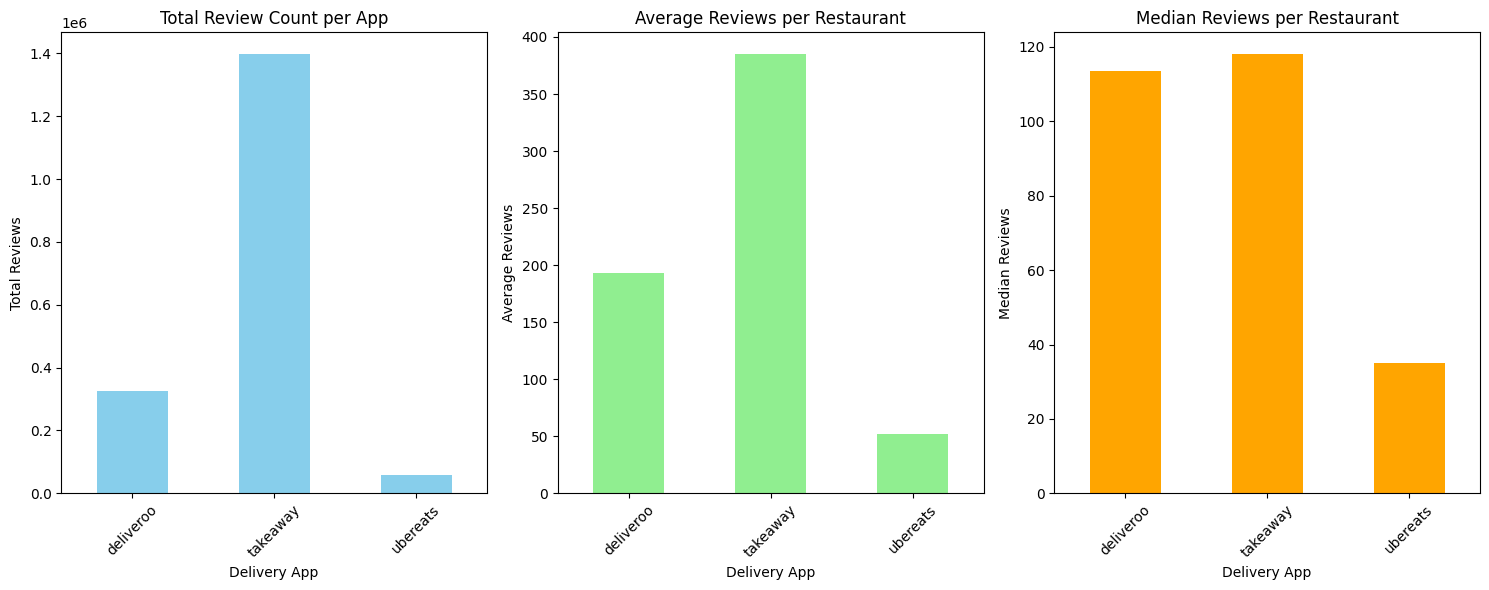

<Figure size 1200x600 with 0 Axes>

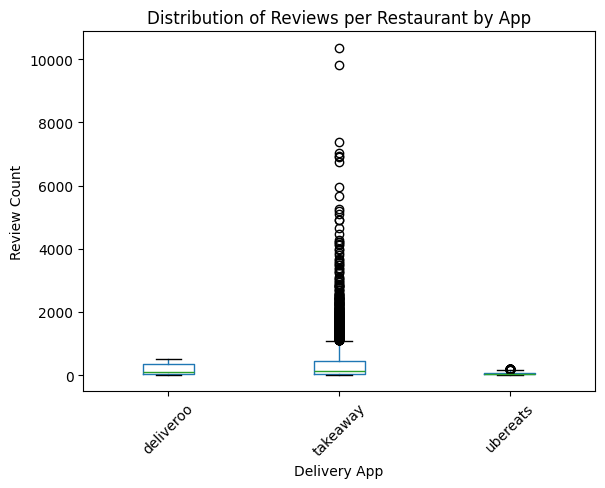

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame with columns 'source' (delivery app), 'rating_number' (review count per restaurant)

# Total review count per app
total_reviews_per_app = df.groupby('source')['rating_number'].sum()

# Average reviews per restaurant for each app
average_reviews_per_restaurant = df.groupby('source')['rating_number'].mean()

# Median reviews per restaurant for each app
median_reviews_per_restaurant = df.groupby('source')['rating_number'].median()

# Plot total review count per app
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
total_reviews_per_app.plot(kind='bar', color='skyblue')
plt.title('Total Review Count per App')
plt.xlabel('Delivery App')
plt.ylabel('Total Reviews')
plt.xticks(rotation=45)

# Plot average reviews per restaurant
plt.subplot(1, 3, 2)
average_reviews_per_restaurant.plot(kind='bar', color='lightgreen')
plt.title('Average Reviews per Restaurant')
plt.xlabel('Delivery App')
plt.ylabel('Average Reviews')
plt.xticks(rotation=45)

# Plot median reviews per restaurant
plt.subplot(1, 3, 3)
median_reviews_per_restaurant.plot(kind='bar', color='orange')
plt.title('Median Reviews per Restaurant')
plt.xlabel('Delivery App')
plt.ylabel('Median Reviews')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Distribution of reviews per restaurant (boxplot)
plt.figure(figsize=(12, 6))
df.boxplot(column='rating_number', by='source', grid=False)
plt.title('Distribution of Reviews per Restaurant by App')
plt.suptitle('')  # Removes automatic subtitle
plt.xlabel('Delivery App')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.show()


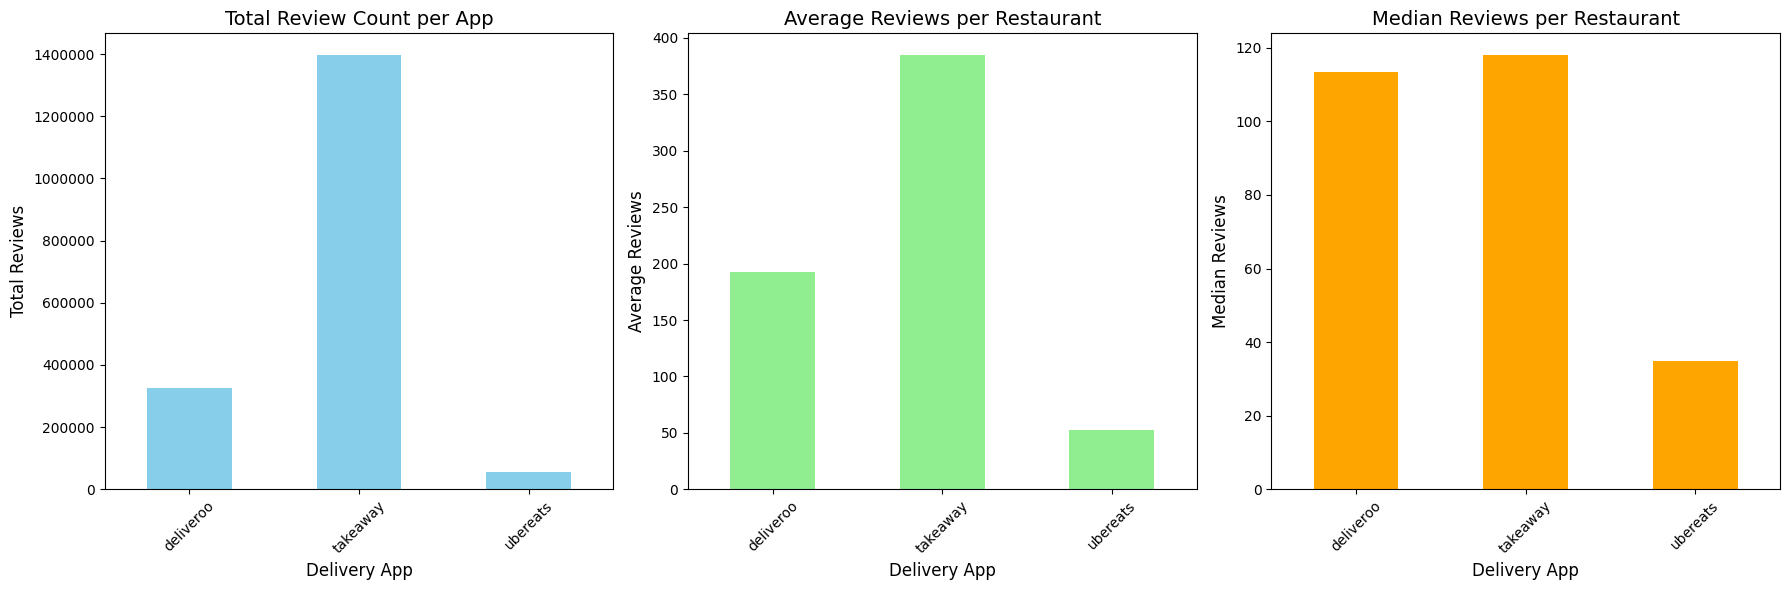

<Figure size 1000x600 with 0 Axes>

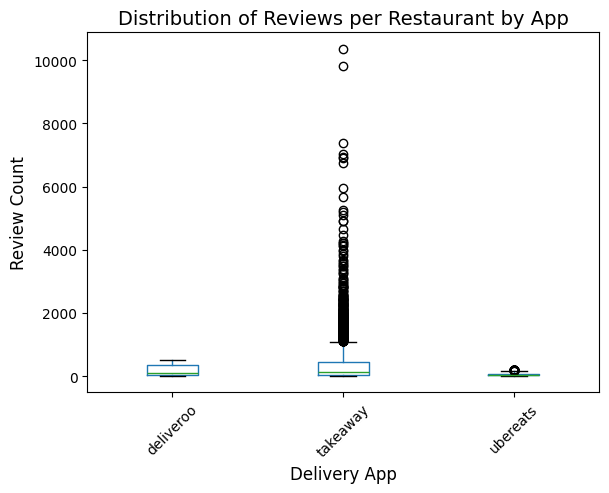

Total count of unique restaurants that have a rating: 5128


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame with columns 'source' (delivery app) and 'rating_number' (review count per restaurant)

# **1. Total Review Count per App**
total_reviews_per_app = df.groupby('source')['rating_number'].sum()

# **2. Average Reviews per Restaurant for Each App**
average_reviews_per_restaurant = df.groupby('source')['rating_number'].mean()

# **3. Median Reviews per Restaurant for Each App**
median_reviews_per_restaurant = df.groupby('source')['rating_number'].median()

# **4. Visualization: Total, Average, and Median Reviews**
plt.figure(figsize=(18, 6))

# **Total Reviews**
plt.subplot(1, 3, 1)
total_reviews_per_app.plot(kind='bar', color='skyblue')
plt.title('Total Review Count per App', fontsize=14)
plt.xlabel('Delivery App', fontsize=12)
plt.ylabel('Total Reviews', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ticklabel_format(style='plain', axis='y')  # Avoid scientific notation

# **Average Reviews**
plt.subplot(1, 3, 2)
average_reviews_per_restaurant.plot(kind='bar', color='lightgreen')
plt.title('Average Reviews per Restaurant', fontsize=14)
plt.xlabel('Delivery App', fontsize=12)
plt.ylabel('Average Reviews', fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# **Median Reviews**
plt.subplot(1, 3, 3)
median_reviews_per_restaurant.plot(kind='bar', color='orange')
plt.title('Median Reviews per Restaurant', fontsize=14)
plt.xlabel('Delivery App', fontsize=12)
plt.ylabel('Median Reviews', fontsize=12)
plt.xticks(rotation=45, fontsize=10)

plt.tight_layout()
plt.show()

# **5. Distribution of Reviews per Restaurant (Boxplot)**
plt.figure(figsize=(10, 6))
df.boxplot(column='rating_number', by='source', grid=False)
plt.title('Distribution of Reviews per Restaurant by App', fontsize=14)
plt.suptitle('')  # Removes automatic subtitle
plt.xlabel('Delivery App', fontsize=12)
plt.ylabel('Review Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.ticklabel_format(style='plain', axis='y')  # Avoid scientific notation
plt.show()

# Total count of unique restaurants that have a rating
unique_restaurants_with_rating = df[df['rating'].notnull()]['restaurant_name'].nunique()
print(f"Total count of unique restaurants that have a rating: {unique_restaurants_with_rating}")

In [8]:
import sqlite3
import pandas as pd

# Path to the UberEats database file
db_file_path = 'databases_uc/ubereats.db'

# Connect to UberEats database
conn = sqlite3.connect(db_file_path)

# Query to count the number of restaurants with more than 500 ratings
query_high_rating_count = """
SELECT COUNT(*) 
FROM restaurants 
WHERE rating__review_count > 500
"""
count_high_rating = pd.read_sql_query(query_high_rating_count, conn).iloc[0, 0]

# Query to count the number of restaurants with 500 or fewer ratings
query_low_rating_count = """
SELECT COUNT(*) 
FROM restaurants 
WHERE rating__review_count <= 500
"""
count_low_rating = pd.read_sql_query(query_low_rating_count, conn).iloc[0, 0]

# Close the connection
conn.close()

# Display the results
print(f"Number of restaurants with more than 500 ratings: {count_high_rating}")
print(f"Number of restaurants with 500 or fewer ratings: {count_low_rating}")


Number of restaurants with more than 500 ratings: 215
Number of restaurants with 500 or fewer ratings: 878
